# Sequency Basics

In [1]:
#standard set of imports that save us time in the future
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from hotstepper import Steps,Step
import hotstepper as hs
from hotstepper import Sequency

If you are familar with Fourier analysis, the concept of Sequency analysis will be easy. If you are not familiar with Fourier analysis, I recommend a very friendly and accessible introduction at [Medium](https://medium.com/sho-jp/fourier-transform-101-part-1-b69ea3cb4837).

With a [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform), we start by assuming we can decompose the dataset into simplier pieces, which in the case of Fourier Analysis, are Sine and Cosine functions that are at different frequencies and different amplitudes. As a simple example, we will generate a test signal and investigate how a decomposition would work and ultimately, what do we get for our trouble.

We will specifically be using the Discete Fast Fourier transform as implemented within [Numpy](https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft).


Why would we want to perform a Fourier transform? what we get is the ability to understand if there is recurring patterns in the data, how often they occur and how strong they are. As a bonus, we can also remove noise and possibility unwanted parts of the data using the same techniques. This may seem obvious is our data is fairly simple, sometimes however, the data is very noisy and there may be many overlapping repeating patterns that may be difficult to spot by eye.

We'll jump into a brief example and then cover the details before we move on. For this example, we will only need the power of HotStepper.

We will use a test function with three differente frequencies and also a linear term so we can see what happens when there is a component that isn't recurring at some regular interval.

Our test function;
$f(t) = t+sin(20t)+3sin(5t)-\frac{sin(15t)}{2}$
$\; t \in \mathbb{R}$.

In [2]:
# Test function
two_pi = 2*np.pi
test_function = lambda t: np.sin(20*t) + 3*np.sin(5*t) - 0.5*np.cos(15*t) + t


We also need to create a range over which we will investigate this function, we will use the proper terminology to ensure we are clear as to why things are the way they are.

In [3]:
# How many time points are needed i,e., Sampling Frequency
samplingFrequency=50

# At what intervals time points are sampled
samplingInterval=1/samplingFrequency

# Begin time period of the signals
beginTime=0

# End time period of the signals
endTime=5

# Time points
time=np.arange(beginTime, endTime, samplingInterval)

Let's have a look at the seperate components of this test function, believe me we will need to understand this simple function better in order to appreciate what is about to be shown.

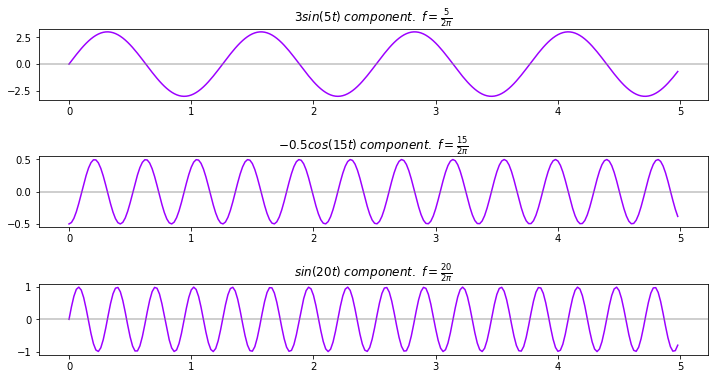

In [4]:
fig, ax = plt.subplots(nrows = 3, figsize=(12,6))
plt.subplots_adjust(hspace=0.8)

# 3*np.sin(5*t) component
ax[0].plot(time,3*np.sin(5*time))
ax[0].set_title(r'$3sin(5t) \; component. \; f = \frac{5}{2\pi}$');
ax[0].axhline(0,color='grey',alpha=0.5)

# -0.5*np.cos(15*t) component
ax[1].plot(time,-0.5*np.cos(15*time))
ax[1].set_title(r'$-0.5cos(15t) \; component. \; f = \frac{15}{2\pi}$');
ax[1].axhline(0,color='grey',alpha=0.5);

# np.sin(20*t) component
ax[2].plot(time,np.sin(20*time))
ax[2].set_title(r'$sin(20t) \; component. \; f = \frac{20}{2\pi}$');
ax[2].axhline(0,color='grey',alpha=0.5);



To better future proof this discussion, we will also calculate something that may seem odd at first, but it will make complete sense in a moment when we unleash the Walsh transform on the test function.

So firstly, we will calculate the actual frquencies of these components. Whilst correct and all nice, the formula representation doesn't help when we are looking at a chart and looking for the value of $\frac{5}{2\pi}$, therefore $\frac{5}{2\pi} = 0.796 Hz$. Now for the rest and in a nicer layout for quick reference later.

We will also calculate the number of zero crossings of each component, this specifically means, how many times does the function **cross** over zero, not the same as how many times is it zero, as they all start at zero.

We can use alittle math to figure this out, as we know that the Sine function is zero whenever the argument is a multiple of $\pi$, Cosine is the same, with an offset of $\frac{\pi}{2}$ from the start.

Using these details, we have calculated the decimal frquencies and sequency numbers for each component.

Test function component frequency values.

In [5]:
test_function_comp_freqs = {}
test_function_comp_freqs['3sin(5t)'] = round(5/(2*np.pi),2)
test_function_comp_freqs['-0.5cos(15t)'] = round(15/(2*np.pi),2)
test_function_comp_freqs['sin(20t)']= round(20/(2*np.pi),2)

print ("{:<15} {:<15}".format('Component','Frequency (Hz)'))
for k, v in test_function_comp_freqs.items():
    print ("{:<15} {:<15}".format(k, v))


Component       Frequency (Hz) 
3sin(5t)        0.8            
-0.5cos(15t)    2.39           
sin(20t)        3.18           


Test function component sequency values.

In [6]:
test_function_comp_seqs = {}
test_function_comp_seqs['3sin(5t)'] = np.ceil(5*two_pi*test_function_comp_freqs['3sin(5t)']/np.pi)-1
test_function_comp_seqs['-0.5cos(15t)']= np.ceil(5*two_pi*test_function_comp_freqs['-0.5cos(15t)']/np.pi)-1
test_function_comp_seqs['sin(20t)']= np.ceil(5*two_pi*test_function_comp_freqs['sin(20t)']/np.pi)-1

print ("{:<15} {:<15}".format('Component','Sequency'))
for k, v in test_function_comp_seqs.items():
    print ("{:<15} {:<15}".format(k, int(v)))


Component       Sequency       
3sin(5t)        7              
-0.5cos(15t)    23             
sin(20t)        31             


## Fourier Transform

Now we have setup everything we need to generate some data and let HotStepper to do the heavy lift, let's rip the bandaid off and get some plots, let the understanding, begin!

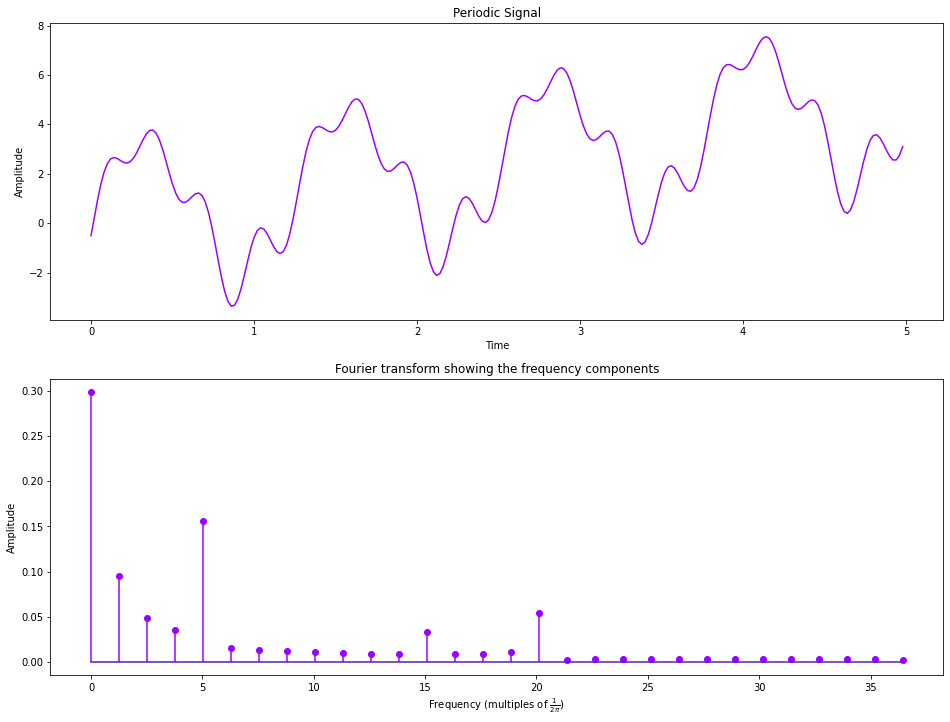

In [16]:
# Generate test function data
data = test_function(time)

# Create subplot
figure, ax = plt.subplots(nrows=2,figsize=(16,12))

# Time domain representation of test function
ax[0].set_title('Periodic Signal')
ax[0].plot(time, data)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')

# Our Sequency object we will use for all our analysis
sequency = Sequency()

# Perform FFT on the test function data
frequencies, spectrum = sequency.frequency_spectrum(data,two_pi*samplingFrequency)

# Frequency domain representation of test function
ax[1].set_title('Fourier transform showing the frequency components')
ax[1].stem(frequencies[:30], spectrum[:30] )
ax[1].set_xlabel('Frequency (multiples of $\\frac{1}{2 \pi}$)')
ax[1].set_ylabel('Amplitude');


In the stem plot we can clearly see the spikes at 5, 15 and 20, just as we would expect, since those are the frequencies we constructed the test function with. We can also note that the relative size of the spikes are 5, 20 and 15, which also makes sense, since we assigned amplitudes of 3, 1 and 0.5 respectively to each of those components, this relative "strength" within the test function was also extracted by the Fourier transform. What is getting interesting is the strong spike at 0, where did this come from? the simple answer is it comes from the straight line we added at the start of the test function (the t out on it's own at the end of the equation). This linear term doesn't cycle through the same values as the value of t increases, as it grows linearly or in a straight line, therefore it has a frequency of 0, since it doesn't repeat at all, nice!

## Walsh Transform

Wait, I thought we were talking about Sequency Analysis, what is the Walsh transform? In the realm of Sequency Analysis, the Walsh transform plays the role of the Fourier transform, with a few differences. It is those delicious differences that make this investigation worth the effort, as the Fourier transform is awesome, no doubt, but it does have some hang ups if we give it data that doesn't play nicely in terms of smoothness and jumpiness? is that a word, it is now. We will have a look at the younger but less well known brother of the Fourier transform, the Welsh transform and will show how whilst Fourier is all that and a bag of potato chips, there are some cases (actually quite a few) where we should use a different method and will be rewarded with more insight and a clearer picture of the nature of the data. Anyways, enough woffling.

The Walsh transform is defined as the sequency ordered Hadamand transform, which is nothing more than a matrix full of -1 and 1's arranged in order of increasing sequency number. Ok ok, sequency number, wtf is that? If we start with the definition of [frequency](https://en.wikipedia.org/wiki/Frequency#:~:text=Frequency%20is%20the%20number%20of,a%20repeating%20event%20per%20second.), in simple terms, the number of times a pattern repeats within an interval T, usually a unit interval of time, such as a second and is defined as;

$f = \frac{1}{T}$

Fair enough, so the definition of [sequency](https://mathworld.wolfram.com/Sequency.html) is similar, except we just use the idea of crossing **through** zero, the number of zero crossings within a given interval.

So we can define sequency as;

S = # of crossing through 0

We can also define the Walsh transform in a manner similar to the Fourier transform, with the bonus that it is a much simplier evaluation. Ok, enough talk, that all sounds good, but get to the Sequency analysis and why I've bothered to read this far, so without further delay, let's have a look at a Walsh transform of our test function.

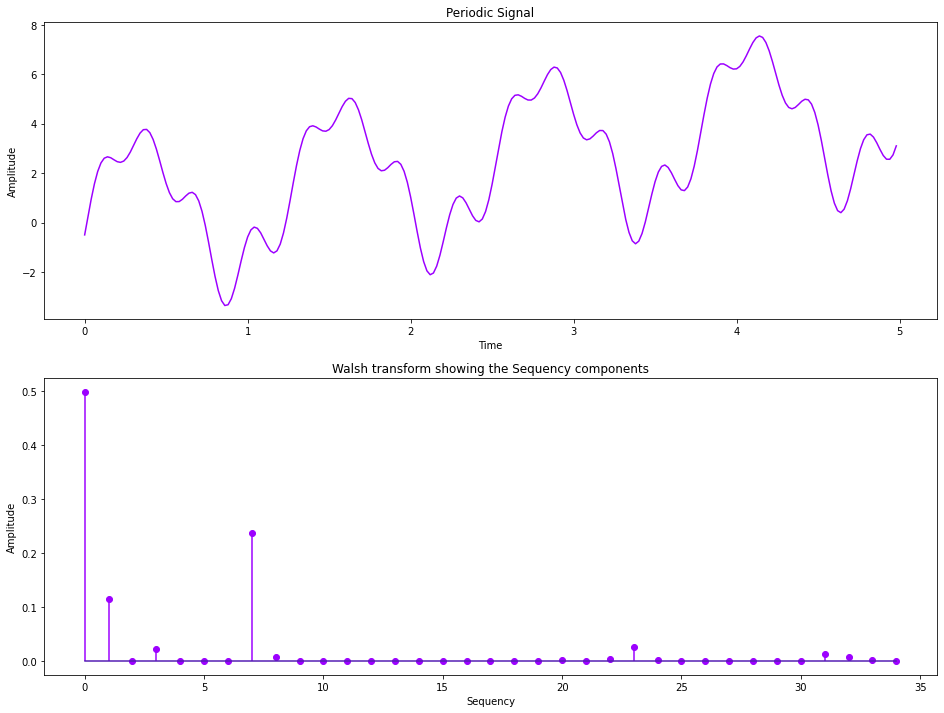

In [8]:
# Generate test function data
data = test_function(time)

# Create subplot
figure, ax = plt.subplots(nrows=2,figsize=(16,12))

# Time domain representation of test function
ax[0].set_title('Periodic Signal')
ax[0].plot(time, data)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')

# Perform FWT on the test function data
sequencies, spectrum, sc = sequency.sequency_spectrum(data)

# Sequency domain representation of test function
ax[1].set_title('Walsh transform showing the Sequency components')
ax[1].stem(sequencies[:35], spectrum[:35] )
ax[1].set_xlabel('Sequency')
ax[1].set_ylabel('Amplitude');


Now we know why we calculated the number of zero crossings for the components of the test function, remember what they are?, 7, 23 and 31. From the sequency spectrum above, we can see strong sequency components at 7, 23, 31. These represent the same components, but they are now represented via Walsh functions and instead of frequency, we have their sequency numbers.

It can also be seen, just as with the Fourier transform, the linear term appears as a strong sequency 0 component and as before, there are a few other terms with some strength at sequency 1 and 3. These represent the same components detected by the Fourier transform, while these components weren't explicitly included, they are present due to the presence of the linear term. The easiest way to see this is to simply remove the linear term and look at the Fourier and Walsh transforms to see the difference.


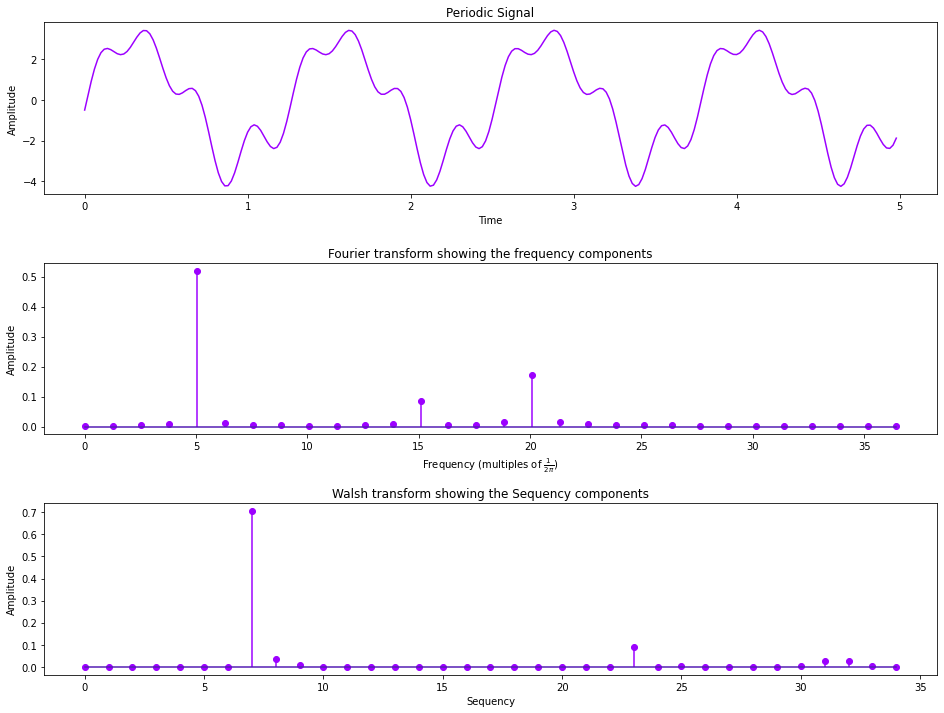

In [17]:
# Remove the linear term from the test function
data = test_function(time)-time

# Create subplot
figure, ax = plt.subplots(nrows=3,figsize=(16,12))
plt.subplots_adjust(hspace=0.4)

# Time domain representation of test function
ax[0].set_title('Periodic Signal')
ax[0].plot(time, data)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')

# Our Sequency object we will use for all our analysis
sequency = Sequency()

# Perform FFT on the test function data
frequencies, spectrum = sequency.frequency_spectrum(data,two_pi*samplingFrequency)

# Frequency domain representation of test function
ax[1].set_title('Fourier transform showing the frequency components')
ax[1].stem(frequencies[:30], spectrum[:30] )
ax[1].set_xlabel('Frequency (multiples of $\\frac{1}{2 \pi}$)')
ax[1].set_ylabel('Amplitude');

# Perform FWT on the test function data
sequencies, spectrum, sc = sequency.sequency_spectrum(data)

# Sequency domain representation of test function
ax[2].set_title('Walsh transform showing the Sequency components')
ax[2].stem(sequencies[:35], spectrum[:35] )
ax[2].set_xlabel('Sequency')
ax[2].set_ylabel('Amplitude');

See, all gone! So now we know all about the Walsh transform and how it is related to the Fourier transform, we can see that it can handle non-step data pretty well, but what it really does well is performs this type of component analysis with proper step data. Let's generate some and take a look.

So that all seems reasonable and all that, it also doesn't seem overly impressive on our test function, as our Fourier transform provided clearer insight as to the frequency components present and to be frank, the spectrum stem plot was prettier! That's fair enough, we also mentioned that Walsh transforms are not always the best, in this case, the data is actually made of Sine and Cosine functions and is therefore better decomposed with a Fourier transform. Now for the rub, what if we have step data, you know, like the kind HotStepper deals with for breakfast? Well, in that case, Walsh transform is more suited, we can see this with a simple example.

In [10]:
# Test step function
steps1 = [Step(start=n,end=n+1.5, weight=(-1)**n) for n in range(1,10)]
steps2 = [Step(start=n,end=n+2.5, weight=(-1)**(n+1)) for n in range(1,20)]
steps3 = [Step(start=n,end=n+3.5, weight=(-1)**n) for n in range(1,18)]

test_steps = Steps().add(steps1);
#test_steps.add(steps2)
#test_steps.add(steps3);

So if we have a look at our test step function and count the number of zero crossings, we count 16 (don't count the first and last zero, as they are not crossing). Now we have an interesting observation, if we use the step values directly in the sequency spectrum analysis, we get a symmetric spectrum. This seems reasonable as the steps data is completely repeating and symmetric around the center of the peaks or troughs. If we use the step change values instead, which represent the delta values between step keys, we see the sequency spectrum is exactly half that of the step values, nice!

Now if we look at the sequency spectrum for the step change, as it is usally of more interest to look at how the step values change instead of their direct values, most of the power is at the 16. There is some at the 17, this comes about due to the way this step function holds the zero value for a moment before the next step change, the creates the need for a small offset, which appears for this step funciton, to be at a sequency number of 17.

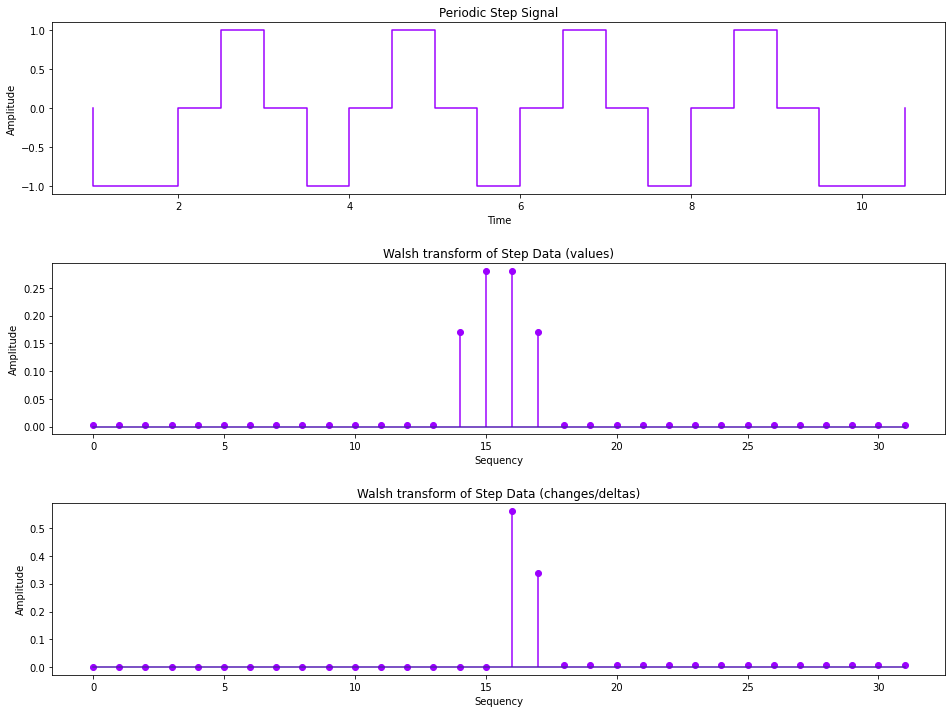

In [11]:
# # Create subplot
figure, (ax,ax2, ax3) = plt.subplots(nrows=3, figsize=(16,12))
plt.subplots_adjust(hspace=0.4)

# Our test steps data
test_steps.plot(ax=ax)
ax.set_title('Periodic Step Signal')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')

# Perform FWT on the test function data
sequencies, spectrum, sc = sequency.sequency_spectrum(test_steps.step_values())

# Sequency domain representation of test function
ax2.set_title('Walsh transform of Step Data (values)')
ax2.stem(sequencies, spectrum )
ax2.set_xlabel('Sequency')
ax2.set_ylabel('Amplitude');

# Perform FWT on the test function data
sequencies, spectrum, sc = sequency.sequency_spectrum(test_steps.step_changes())

# Sequency domain representation of test function
ax3.set_title('Walsh transform of Step Data (changes/deltas)')
ax3.stem(sequencies, spectrum )
ax3.set_xlabel('Sequency')
ax3.set_ylabel('Amplitude');


## Denoising (Fourier and Walsh)

Let's do some denoising with both Fourier and Walsh transforms. We will see that they are both pretty good on our test function, however the nature of the data comes into play, as you will see in a moment. Fourier for smooth data, Walsh for step data, this will be clear in a moment, as the denoising will show the preference each transform method has when processing the data.

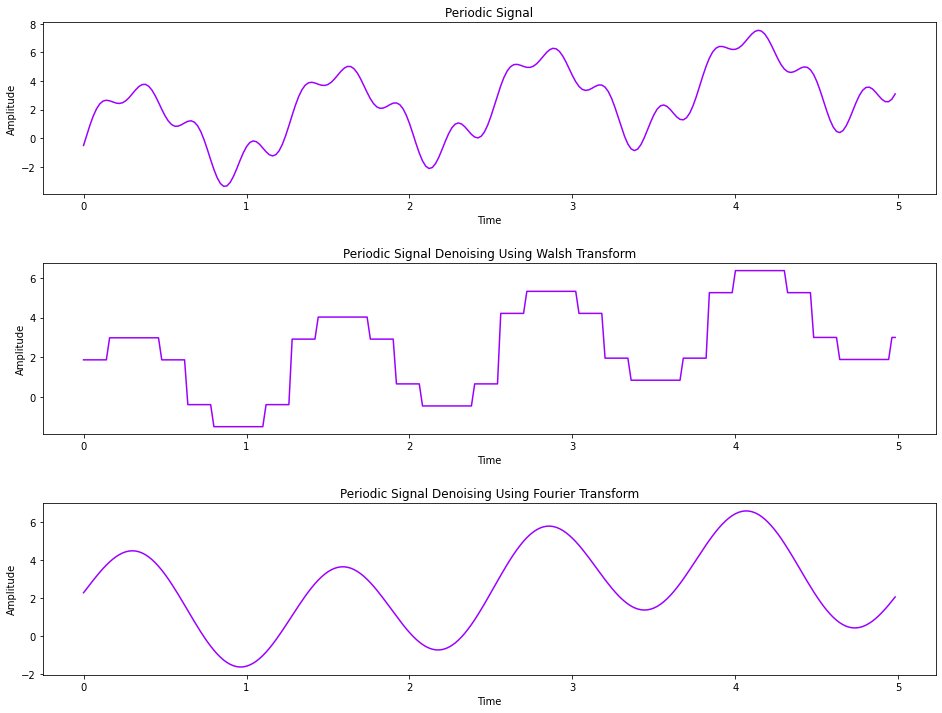

In [12]:
# Generate test function data
data = test_function(time)

# Create subplot
figure, ax = plt.subplots(nrows=3,figsize=(16,12))
plt.subplots_adjust(hspace=0.4)

# Time domain representation of test function
ax[0].set_title('Periodic Signal')
ax[0].plot(time, data)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')

# Perform Walsh transform denoising using value threshold method
dnw = sequency.denoise(data,method='walsh',denoise_strength=0.2)

# Perform Fourier transform denoising using value threshold method
dnf = sequency.denoise(data,method='fourier',denoise_strength=0.2)

# Time domain representation of test function
ax[1].set_title('Periodic Signal Denoising Using Walsh Transform')
ax[1].plot(time, dnw)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude');

# Time domain representation of test function
ax[2].set_title('Periodic Signal Denoising Using Fourier Transform')
ax[2].plot(time, dnf)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Amplitude');


Lastly, we can see that as we would hopefully expect at this point, the Walsh denoising of the smooth data turned it into step data. The Fourier method simply took more of the wiggles out and hence we have an even more Sine wave looking smooth test function.

As a last example, we will apply smoothing to step data using both methods and see what we get, atleast we can compare the results against step data, since we already saw the results against smooth data.

In [13]:
# We'll add some more steps to our previous test_steps
test_steps.add(steps2)
test_steps.add(steps3);

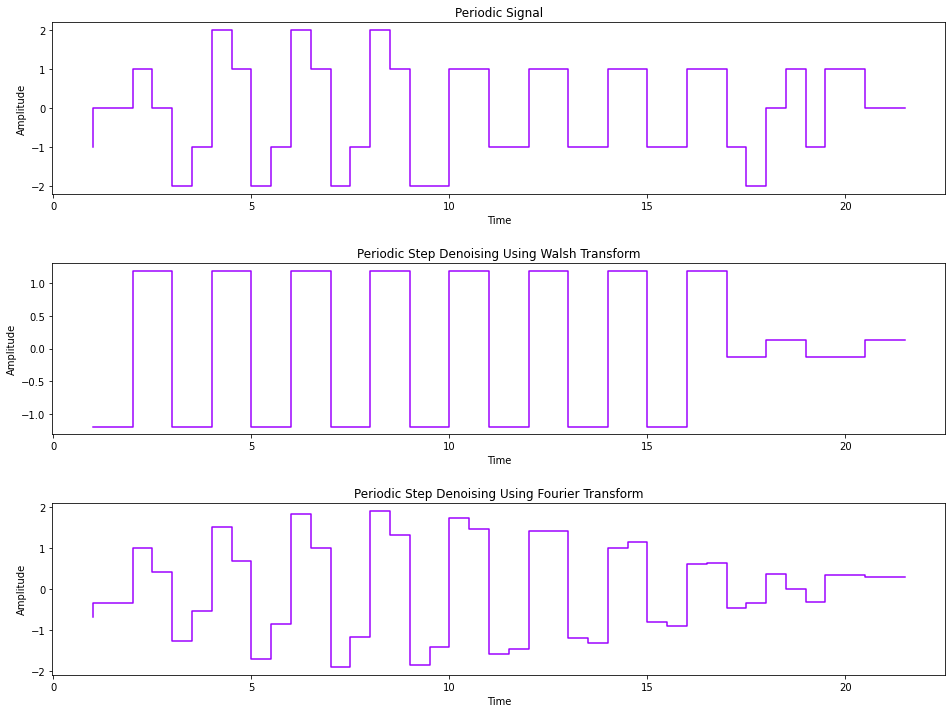

In [14]:
# Generate test function data
data = test_steps.step_values()

# Create subplot
figure, ax = plt.subplots(nrows=3,figsize=(16,12))
plt.subplots_adjust(hspace=0.4)

# Time domain representation of test function
ax[0].set_title('Periodic Signal')
ax[0].step(test_steps.step_keys(), data)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')

# Perform Walsh transform denoising using value threshold method
dnw = sequency.denoise(data,method='walsh',denoise_strength=0.5)

# Perform Fourier transform denoising using value threshold method
dnf = sequency.denoise(data,method='fourier',denoise_strength=0.5)

# Walsh denoising
ax[1].set_title('Periodic Step Denoising Using Walsh Transform')
ax[1].step(test_steps.step_keys(), dnw)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude');

# Fourier denoising
ax[2].set_title('Periodic Step Denoising Using Fourier Transform')
ax[2].step(test_steps.step_keys(), dnf)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Amplitude');



From the last denoising of step data using both Walsh and Fourier methods, we can see that whilst the Walsh method 'Stepifies' smooth data during the denoising process and the Fourier method works very well, they both yield good results. We can seee though when we have step data, a comparison of the denoising methods yields a different picture. The Walsh method does exactl what we would expect, it basically makes the original step data more blocky by removing higher sequency steps, the Fourier method starts to look more like step data encapsulated in a Sine function. This isn't unexpected, it does reveal though that whilst both methods are very useful, the Walsh method slightly edges the Fourier method in terms of range of applicability, atleast based on these scenarios. At the end of the day, both methods have been included in the HotStepper library, since HotStepper is able to process smooth and step data with ease.

I do recommend the use of the Walsh method with the data is step like, as the results will be neater and somewhat more inline with expectations of what denoising and decomposition would produce when dealing with step data.